In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn, optim

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.utils.data import DataLoader, TensorDataset

from statistics import stdev

# Classifier definition

In [4]:
class ClassifierNet(torch.nn.Module):

    def __init__(self):
        super(ClassifierNet, self).__init__()

        self.hidden0 = nn.Sequential(
            nn.Linear(2, 50),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x

# Target distribution

In [5]:
theta_true = 0.
true_dist = Normal(theta_true, 1.)

# Classifier instance: load persisted one or train a new one

In [6]:
def train_s(min_bound, max_bound, model_name):
    U = Uniform(min_bound, max_bound)

    n_thetas = 1000
    x_per_theta = 1000
    training_set_size = n_thetas * x_per_theta
    X = torch.empty(training_set_size, 2)
    Y = torch.empty(training_set_size, 1)
    
    theta_fake = (min_bound + max_bound) / 2.

    for i in range(0, n_thetas):
        theta = U.sample().item()
        for j in range(0, x_per_theta, 2):

            x = Normal(theta, 1.).sample().item()

            X[i*x_per_theta+j] = torch.tensor([theta, x])
            Y[i*x_per_theta+j] = 1.

            x_fake = Normal(theta_fake, 1.).sample().item()

            X[i*x_per_theta+j+1] = torch.tensor([theta, x_fake])
            Y[i*x_per_theta+j+1] = 0.

    dataset = TensorDataset(X, Y)
    data_loader = DataLoader(dataset, batch_size=100, shuffle=False)

    #train a net
    loss = nn.BCELoss()
    s = ClassifierNet()
    optimizer = optim.Adam(s.parameters(), lr=0.0002)

    num_epochs = 100

    for epoch in range(num_epochs):
        if((epoch+1) % 1 == 0):
            print("Epoch {} of {}".format(epoch+1, num_epochs))
        for n_batch, batch in enumerate(data_loader):
            x = batch[0]
            y = batch[1]
            optimizer.zero_grad()

            y_hat = s(x)
            error = loss(y_hat, y)
            error.backward()
            optimizer.step()
            
    torch.save(s, model_name)
    
    return s

try:
    s = torch.load("classifier_1.dat")
except FileNotFoundError:
    s = train_s(-10., 10., "classifier_1.dat")


# Analytical LR vs. Classifier LR

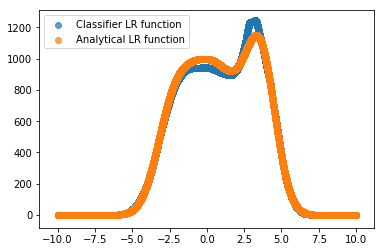

In [6]:
n_obs = 1000
true_obs = true_dist.sample(torch.Size([n_obs])).view(-1, 1)

def analytical_lr(theta, observations):
    p_true = Normal(0., 1.)
    p_other = Normal(theta, 1.)

    return (p_other.log_prob(observations).exp() / p_true.log_prob(observations).exp()).sum()

def classifier_lr(theta, observations, s):
    input = theta.view(-1, 1).repeat(n_obs, 1)
    input = torch.cat((input, observations), 1)
    _s = s(input)
    lr = (_s) / (1 - _s)
    return lr.sum()

min_x = np.amin(-10.)
max_x = np.amax(10.)
thetas_range = np.linspace(float(min_x), float(max_x), 30000)

a_lr = []
c_lr = []
for theta in thetas_range:
    a_lr.append(analytical_lr(theta, true_obs).item())
    c_lr.append(classifier_lr(torch.tensor([theta]), true_obs, s).item())

plt.scatter(thetas_range, c_lr, alpha=.7, label="Classifier LR function")
plt.scatter(thetas_range, a_lr, alpha=.7, label="Analytical LR function")
plt.legend()
plt.show()

# Recursive LFI with MH MCMC

In [38]:
def mh_mcmc(s, current_min_bound, current_max_bound):
    U = Uniform(current_min_bound, current_max_bound)
    theta_current = U.sample()
    print(theta_current)
    steps = 1000
    thetas = []

    n_obs = 1000
    true_obs = true_dist.sample(torch.Size([n_obs])).view(-1, 1)

    for i in range(steps):
        #print("Iteration {} of {}".format(i+1, steps))

        proposal = Normal(theta_current, torch.tensor([1.]))
        theta_next = proposal.sample()

        if(theta_next < current_min_bound or 
           theta_next > current_max_bound):
            acceptance = 0
        else:
            input_current = theta_current.view(-1, 1).repeat(n_obs, 1)
            input_current = torch.cat((input_current, true_obs), 1)
            s_current = s(input_current)
            lr_current = (s_current) / (1 - s_current)

            input_next = theta_next.view(-1, 1).repeat(n_obs, 1)
            input_next = torch.cat((input_next, true_obs), 1)
            s_next = s(input_next)
            lr_next = (s_next) / (1 - s_next)

            lr = (lr_next.log().sum() - lr_current.log().sum()).exp()
            acceptance = min(1, lr.item())

        if np.random.uniform() <= acceptance:
            theta_current = theta_next
            #print("ACCEPTED new theta: {}".format(theta_current.item()))

        thetas.append(theta_current.item())

    mean_theta = sum(thetas) / float(len(thetas))
    sd = stdev(thetas)
    min_bound = mean_theta - sd
    max_bound = mean_theta+ sd
    print("Mean theta: {}".format(mean_theta))
    print("New bounds: [{};{}]".format(min_bound, max_bound))
    print("##########################")
    return min_bound, max_bound
    
#s = torch.load("classifier_3.dat")
#train_s(-0.012573526295767381, 0.021613388819554106, "classifier_4.dat")


# Likelihood free inference with Hamiltonian MC

In [7]:
theta_current = torch.tensor([5.0])
steps = 1000
thetas = []

n_obs = 1000
true_obs = true_dist.sample(torch.Size([n_obs])).view(-1, 1)

def ref_likelihood(observations):
    return Normal(0., 1.).log_prob(observations).exp()

def U(theta, observations, s):
    input = theta.view(-1, 1).repeat(n_obs, 1)
    input = torch.cat((input, observations), 1)
    _s = s(input)
    lr = (_s) / (1 - _s)
    likelihood = lr * ref_likelihood(observations)
    return -likelihood.log().sum()

def dU(theta, observations, s):
    theta_var = torch.autograd.Variable(theta, requires_grad=True)
    out = U(theta_var, observations, s)
    out.backward()
    gradient = theta_var.grad
    theta_var.detach()
    return gradient

def K(momentum):
    return ((momentum * momentum) / 2).sum()

def dK(momentum):
    momentum_var = torch.autograd.Variable(momentum, requires_grad=True)
    out = K(momentum_var)
    out.backward()
    gradient = momentum_var.grad
    momentum_var.detach()
    return gradient

momentum_dist = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
leapfrog_steps = 30
leapfrog_stepsize = 0.0005

for i in range(steps):
    #print("Iteration {} of {}".format(i+1, steps))

    momentum = momentum_dist.rsample()

    momentum_next = momentum
    theta_next = theta_current

    for j in range(leapfrog_steps):
        momentum_next = momentum_next - (leapfrog_stepsize / 2) * dU(theta_next, true_obs, s)
        theta_next = theta_next + leapfrog_stepsize * dK(momentum_next)
        momentum_next = momentum_next - (leapfrog_stepsize / 2) * dU(theta_next, true_obs, s)

    rho = (U(theta_current, true_obs, s) - U(theta_next, true_obs, s)) - \
          K(momentum_next) + K(momentum)

    rho = rho.exp()
    u = np.random.uniform()
    a = min([1, rho])

    #print("Current: {}".format(theta_current.item()))
    #print("Next: {}".format(theta_next.item()))
    #print("Rho: {}".format(rho))

    if u <= a:
        theta_current = theta_next
        #print("ACCEPTED")
    #print("####################\n")

    thetas.append(theta_current.item())

mean_theta = sum(thetas) / float(len(thetas))
print("Mean of estimated thetas: {}".format(mean_theta))

Mean of estimated thetas: 0.10418816389702261
